In [18]:
# Import libaries
import pandas as pd
import os
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import mysql.connector

## Getting Data from MySQL Database

In [19]:
def get_data(query):
    host = os.environ.get("MYSQL_HOST", "localhost")
    port = os.environ.get("MYSQL_PORT", "3306")
    dbname = os.environ.get("MYSQL_DBNAME", "test")
    user = os.environ.get("MYSQL_USER", "root")
    password = os.environ.get("MYSQL_PASSWORD", "")

    try:
        conn = mysql.connector.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=dbname
        )
        if conn.is_connected():
            # Create a cursor
            cursor = conn.cursor()
            
            # Execute the query
            cursor.execute(query)
            
            # Fetch the results into a Pandas DataFrame
            result = cursor.fetchall()
            df = pd.DataFrame(result, columns=cursor.column_names)
            return df
        else:
            print("Connection to MySQL database failed.")
    except mysql.connector.Error as err:
        print(f"Error: {err}")



In [20]:
# Getting charger data from MySQL database with custom query
query = "SELECT canton, COUNT(*) AS count FROM charger_data_with_canton GROUP BY canton ORDER BY canton ASC"

# Get data from MySQL database
df_canton_count = get_data(query)

query = "SELECT * FROM canton_data ORDER By canton ASC"

df_canton_data = get_data(query)

# Merge dataframes
df = pd.merge(df_canton_data, df_canton_count, on='canton')

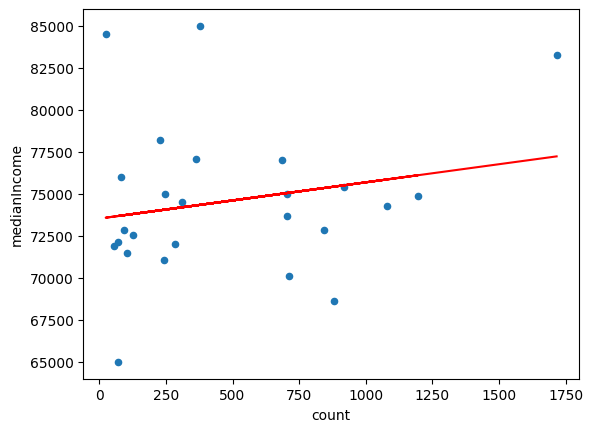

In [21]:
# Fit a line to the data using polyfit
m, b = np.polyfit(df['count'], df['medianIncome'], 1)

# Add the line to the scatter plot
ax = df.plot(x='count', y='medianIncome', kind='scatter')
ax.plot(df['count'], m*df['count'] + b, color='red')


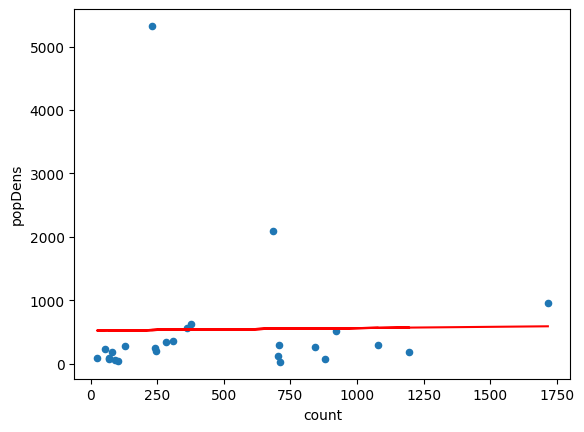

In [22]:
# Fit a line to the data using polyfit
m, b = np.polyfit(df['count'], df['popDens'], 1)

# Add the line to the scatter plot
ax = df.plot(x='count', y='popDens', kind='scatter')
ax.plot(df['count'], m*df['count'] + b, color='red')

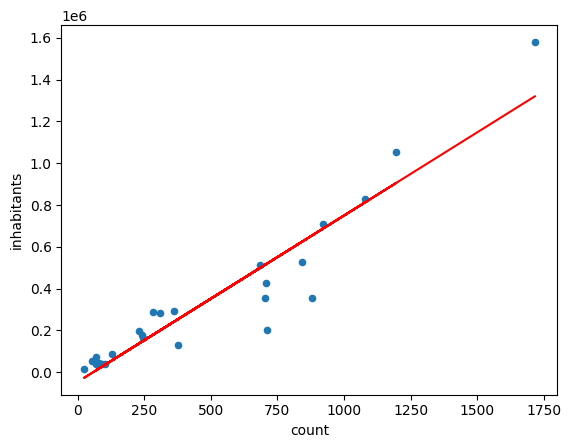

In [23]:
# Fit a line to the data using polyfit
m, b = np.polyfit(df['count'], df['inhabitants'], 1)

# Add the line to the scatter plot
ax = df.plot(x='count', y='inhabitants', kind='scatter')
ax.plot(df['count'], m*df['count'] + b, color='red')

## Regression Trees

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df[['popDens',
                                                        'medianIncome', 'inhabitants']], 
                                                        df['count'], 
                                                        test_size=0.20, 
                                                        random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
    popDens  medianIncome  inhabitants
9      88.1         65000        73865
13     80.5         72123        38700
1     229.6         71911        55759
22     68.5         68624       357282
5     180.1         74886      1051437 

y_train:
9       71
13      69
1       54
22     879
5     1196
Name: count, dtype: int64


# Fit the regression tree model

In [25]:


# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=5)

# Train decision tree regressor
reg = reg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = reg.predict(X_test)

# Calculate coefficient of determination (R-squared)

In [26]:


# Calculate coefficient of determination
print('R-squared:', r2_score(y_test, y_pred).round(4))

R-squared: 0.1667


In [27]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

|--- inhabitants <= 324220.00
|   |--- inhabitants <= 125067.00
|   |   |--- medianIncome <= 80256.50
|   |   |   |--- popDens <= 257.70
|   |   |   |   |--- popDens <= 70.70
|   |   |   |   |   |--- value: [97.00]
|   |   |   |   |--- popDens >  70.70
|   |   |   |   |   |--- value: [68.75]
|   |   |   |--- popDens >  257.70
|   |   |   |   |--- value: [128.00]
|   |   |--- medianIncome >  80256.50
|   |   |   |--- value: [24.00]
|   |--- inhabitants >  125067.00
|   |   |--- inhabitants <= 292033.50
|   |   |   |--- medianIncome <= 73507.50
|   |   |   |   |--- value: [284.00]
|   |   |   |--- medianIncome >  73507.50
|   |   |   |   |--- popDens <= 2759.70
|   |   |   |   |   |--- value: [246.00]
|   |   |   |   |--- popDens >  2759.70
|   |   |   |   |   |--- value: [229.00]
|   |   |--- inhabitants >  292033.50
|   |   |   |--- value: [362.00]
|--- inhabitants >  324220.00
|   |--- medianIncome <= 80135.50
|   |   |--- inhabitants <= 678199.00
|   |   |   |--- medianIncome <= 7327

# Visualize the regression tree

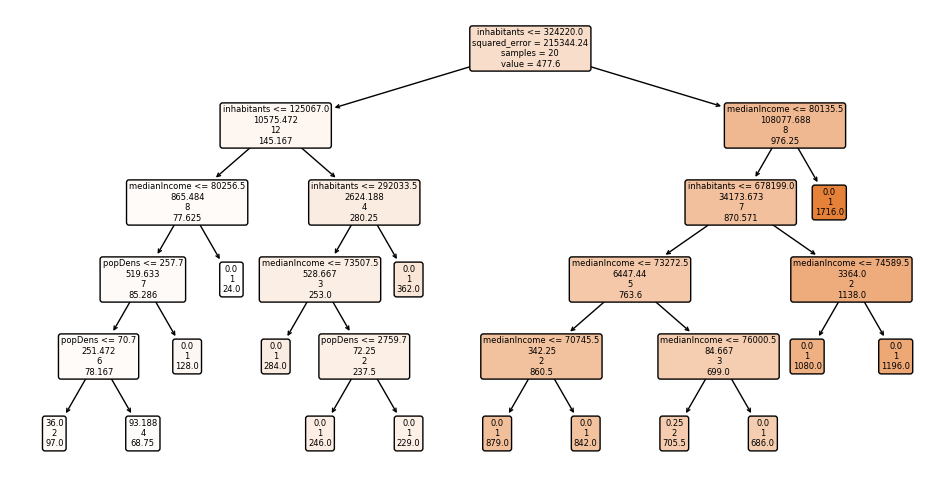

In [28]:


fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=6,
                   label='root',
                   rounded=True)

# Create random forest regression

In [29]:


# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[[ 'popDens',
                                                            'medianIncome', 'inhabitants']], 
                                                            df['count'], 
                                                            test_size=0.20, 
                                                            random_state=42)

# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
    popDens  medianIncome  inhabitants
9      88.1         65000        73865
13     80.5         72123        38700
1     229.6         71911        55759
22     68.5         68624       357282
5     180.1         74886      1051437 

y2_train:
9       71
13      69
1       54
22     879
5     1196
Name: count, dtype: int64


# Fit the random forest regression model

In [30]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X2_test, y2_test).round(4))

R-squared: 0.2278


Index(['inhabitants', 'medianIncome', 'popDens'], dtype='object')
[0.93389992 0.041607   0.02449308]


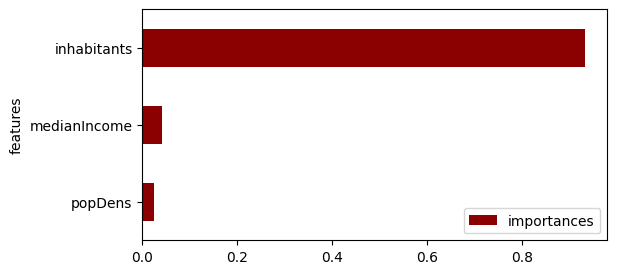

In [31]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

plt.show()